# 导入函数库

In [1]:
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.set_default_dtype(torch.float64)

# 经验池子

In [3]:
class memory:
  def __init__(self, env, memory_length=20000, memory_minibatch=32):
    self.env = env
    self.memory_length = memory_length
    self.memory_minibatch = memory_minibatch

    self.state_size = self.env.observation_space.shape[0]
    try:self.action_size = self.env.action_space.shape[0]
    except:self.action_size = 1
    
    self.memory_width = self.state_size * 2 + self.action_size + 1
    self.memory = np.zeros((self.memory_length, self.memory_width))

    self.index = 0
    self.max_index = 0

  def store(self, state, action, reward, next_state):
    transacton = np.hstack((state, action, reward, next_state))
    self.memory[self.index,:] = transacton

    self.index += 1
    if self.index % self.memory_length == 0:
      self.index = 0
    if self.max_index < self.memory_length:
      self.max_index += 1
  
  def sample(self):
    choice_random = np.random.choice(self.max_index, self.memory_minibatch)
    choice_data = self.memory[choice_random,:]
    state = choice_data[:,0:self.state_size]
    action = choice_data[:,self.state_size:self.state_size+self.action_size]
    reward = choice_data[:,self.state_size+self.action_size:
                         self.state_size+self.action_size+1]
    next_state = choice_data[:,self.state_size+self.action_size+1:]

    reward = np.squeeze(reward)
    if self.action_size == 1:
      action = np.squeeze(action)
    return state, action, reward, next_state


In [ ]:
# env = gym.make('CartPole-v0')
# memory_test = memory(env)
# state = env.reset()
# for _ in range(50):
#   action = env.action_space.sample()
#   next_state, reward, done, _ = env.step(action)
#   memory_test.store(state, action, reward, next_state)
#   state = next_state
# state, action, reward, next_state = memory_test.sample()
# import pdb; pdb.set_trace()
# print('state')

# 神经网络

In [ ]:
class network:
  def __init__(self, env, hidden_dimension=100, learning_rate=1e-3):
    self.env = env
    self.hidden_dimension = hidden_dimension
    self.learning_rate = learning_rate

    self.input_dimension = self.env.observation_space.shape[0]
    self.output_dimension = self.env.action_space.n
    
    self.model = self.__create_network()
    self.loss = torch.nn.MSELoss()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
  
  @staticmethod
  def replace(network_from, network_to):
    network_to.load_state_dict(network_from.state_dict())

  @staticmethod
  def optimizer(predict_object, predict_value, target_value):
    loss = predict_object.loss(predict_value, target_value)
    predict_object.optimizer.zero_grad()
    loss.backward()
    predict_object.optimizer.step()
    return loss.item()
  
  def __call__(self, state):
    action_value = self.model(state)
    return action_value

  def __create_network(self):
    return torch.nn.Sequential(torch.nn.Linear(self.input_dimension,self.hidden_dimension),
                            torch.nn.ReLU(),
                            torch.nn.Linear(self.hidden_dimension,self.output_dimension))

In [ ]:
# env = gym.make('CartPole-v0')
# state_array = []
# for i in range(32):
#   state = env.reset();state_array.append(state.tolist())
# state = torch.from_numpy(np.array(state_array))
# model_test1 = network(env);model_test2 = network(env)
# # print(model_test1.model(state));print(model_test2.model(state))
# # print(model_test1.model(state) - model_test2.model(state))
# # network.replace(model_test1.model,model_test2.model)
# print(model_test1.model(state) - model_test2.model(state))

# for _ in range(1000):
#   optimizer = model_test1.optimizer
#   value1 = model_test1(state);value2 = model_test2(state);
#   value2 = torch.from_numpy(np.array(value2.tolist()))
#   loss = network.optimizer(model_test1,value1,value2)

# print(model_test1(state) - model_test2(state))

# 深度Q学习

## 深度Q学习智能体

In [ ]:
class agent_q:
  def __init__(self, env, epislon_method=1, gamma=0.99):
    self.env = env
    self.epislon_method = epislon_method
    self.gamma = gamma

    if self.epislon_method == 1:
      self.epislon_method =self.epislon_method_1()

    self.q_network = network(self.env)
    self.q_network_target = network(self.env)
    self.memory = memory(self.env)

    pass

  def output_action(self, state):
    state = torch.from_numpy(state)
    action_value = self.q_network(state)
    action_value = np.array(action_value.tolist())

    random_number = np.random.random()
    if random_number > self.epislon_method.epislon_init:
      action = self.env.action_space.sample()
    else:
      action = np.argmax(action_value)
      action = np.squeeze(action)
    return action, action_value
  
  def sample_postprocess(self):
    state, action, reward, next_state = self.memory.sample()
    state = torch.from_numpy(state)
    next_state = torch.from_numpy(next_state)
    action = np.squeeze(action)
    reward = np.squeeze(reward)
    action = action.astype(np.int32)
    return state, action, reward, next_state
  
  def learn(self):
    state, action, reward, next_state = self.sample_postprocess()
    target_value_max, target_action_max = torch.max(self.q_network_target.model(next_state), axis=1)
    target_value = reward + self.gamma*np.array(target_value_max.tolist())

    predict_value_all = self.q_network.model(state)

    replace_index = np.arange(self.memory.memory_minibatch, dtype=np.int32)
    target_value_all = np.array(predict_value_all.tolist())
    target_value_all[replace_index,action] = target_value

    self.epislon_method.update()

    return network.optimizer(self.q_network, predict_value_all,
                      torch.from_numpy(target_value_all))

  class epislon_method_1:
    def __init__(self):
      self.epislon_init = 0.01
      self.epislon_increment = 1.001
      self.epislon_max = 0.9
    def update(self):
      if self.epislon_init < self.epislon_max:
        self.epislon_init *= self.epislon_increment
  
  class epislon_method_2:
    def __init__(self):
      self.epislon_init = 0.9
    def update(self):
      pass

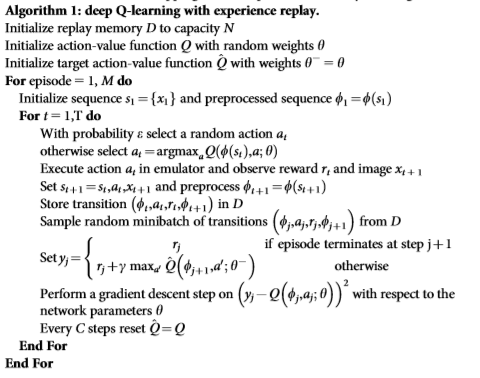

## 深度Q学习环境交互

In [ ]:
class interactive:
  def __init__(self, env_name='CartPole-v0', epoch_max=1000, epoch_replace=10):
    self.env_name = env_name
    self.epoch_max = epoch_max
    self.epoch_replace = epoch_replace

    self.env = gym.make(self.env_name)
    self.env = self.env.unwrapped
    self.agent = agent_q(self.env)

  def reward_normalize(self, next_state):
    x, x_dot, theta, theta_dot = next_state
    r1 = (self.env.x_threshold - abs(x))/self.env.x_threshold - 0.8
    r2 = (self.env.theta_threshold_radians - abs(theta))/self.env.theta_threshold_radians - 0.5
    reward = r1 + r2
    return reward
  
  def start_execute(self):
    self.epoch_index = 0
    self.loss_value = 0
    for i in range(self.epoch_max):
      self.epoch_index += 1
      state = self.env.reset()
      self.epoch_step = 0
      while True:
        self.epoch_step += 1
        action, _ = self.agent.output_action(state)
        next_state, reward, done, info = self.env.step(action)
        reward = self.reward_normalize(next_state)
        self.agent.memory.store(state, action, reward, next_state)
        state = next_state

        if self.epoch_index > 1:
          self.loss_value = self.agent.learn()
        if done or self.epoch_step>1000:
          break
        
      if self.epoch_index % self.epoch_replace == 0:
        network.replace(self.agent.q_network.model, 
                        self.agent.q_network_target.model)
      self.statistic()

  def statistic(self):
    if not self.epoch_index > 1:
      self.epoch_step_list = []
      self.loss_value_list = []
    else:
      print('epoch %-5s, length %-5s, loss_value %5f, epislon %5f'%
            (self.epoch_index, self.epoch_step, self.loss_value, self.agent.epislon_method.epislon_init))
      self.epoch_step_list.append(self.epoch_step)
      self.loss_value_list.append(self.loss_value)

## 深度Q学习执行

当loss在不断变大的过程中，一般原因是学习过程中target估计的值不对。估计的值不对的原因，一方面要考虑算法伪代码实现过程中的问题，另一方面，reward设置无法正常引导环境互动，且贪婪策略的值改变过快，或者是target的replace过程过快，也会导致该种问题的出现。

In [ ]:
dqn_evoluate = interactive(epoch_max=300)
dqn_evoluate.start_execute()

epoch 2    , length 20   , loss_value 0.065915, epislon 0.010202
epoch 3    , length 42   , loss_value 0.029542, epislon 0.010639
epoch 4    , length 24   , loss_value 0.026850, epislon 0.010898
epoch 5    , length 24   , loss_value 0.038773, epislon 0.011162
epoch 6    , length 15   , loss_value 0.022158, epislon 0.011331
epoch 7    , length 49   , loss_value 0.029771, epislon 0.011900
epoch 8    , length 26   , loss_value 0.034958, epislon 0.012213
epoch 9    , length 21   , loss_value 0.023086, epislon 0.012472
epoch 10   , length 31   , loss_value 0.014268, epislon 0.012864
epoch 11   , length 13   , loss_value 0.039779, epislon 0.013033
epoch 12   , length 31   , loss_value 0.042969, epislon 0.013443
epoch 13   , length 30   , loss_value 0.035494, epislon 0.013852
epoch 14   , length 20   , loss_value 0.029234, epislon 0.014132
epoch 15   , length 18   , loss_value 0.023579, epislon 0.014388
epoch 16   , length 51   , loss_value 0.018587, epislon 0.015141
epoch 17   , length 21   

In [ ]:
# figure = plt.figure()
# ax1 = figure.add_subplot(111)
# ax1.plot(dqn_evoluate.epoch_step_list)
# ax2 = ax1.twinx()
# ax2.plot(dqn_evoluate.loss_value_list,c='r')
# plt.show()

# 深度双Q学习

## 深度双Q学习智能体&交互环境

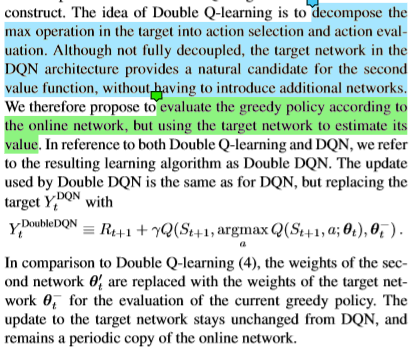

In [ ]:
class agent_double_q(agent_q):
  def learn(self):
    state, action, reward, next_state = self.sample_postprocess()
    # import pdb; pdb.set_trace()
    _ , action_max = torch.max(self.q_network.model(next_state), axis=1)
    target_value = self.q_network_target.model(next_state)
    target_value = np.array(target_value.tolist())
    replace_index = np.arange(self.memory.memory_minibatch, dtype=np.int32)
    target_value = target_value[replace_index, action_max]

    target_value = reward + self.gamma*np.array(target_value.tolist())

    predict_value_all = self.q_network.model(state)

    replace_index = np.arange(self.memory.memory_minibatch, dtype=np.int32)
    target_value_all = np.array(predict_value_all.tolist())
    target_value_all[replace_index,action] = target_value

    self.epislon_method.update()

    return network.optimizer(self.q_network, predict_value_all,
                            torch.from_numpy(target_value_all))


In [ ]:
class interactive_double_q(interactive):
  def __init__(self, env_name='CartPole-v0', epoch_max=1000, epoch_replace=10):
    super().__init__()
    self.env_name = env_name
    self.epoch_max = epoch_max
    self.epoch_replace = epoch_replace
    self.agent = agent_double_q(self.env)

## 深度双Q学习执行

In [ ]:
double_dqn_evoluate = interactive_double_q(epoch_max=300)
double_dqn_evoluate.start_execute()

epoch 2    , length 16   , loss_value 0.038992, epislon 0.010161
epoch 3    , length 19   , loss_value 0.063931, epislon 0.010356
epoch 4    , length 30   , loss_value 0.025348, epislon 0.010671
epoch 5    , length 11   , loss_value 0.042287, epislon 0.010789
epoch 6    , length 25   , loss_value 0.034675, epislon 0.011062
epoch 7    , length 17   , loss_value 0.034312, epislon 0.011252
epoch 8    , length 11   , loss_value 0.040112, epislon 0.011376
epoch 9    , length 21   , loss_value 0.048874, epislon 0.011617
epoch 10   , length 54   , loss_value 0.030592, epislon 0.012262
epoch 11   , length 24   , loss_value 0.043987, epislon 0.012559
epoch 12   , length 17   , loss_value 0.046419, epislon 0.012775
epoch 13   , length 14   , loss_value 0.032272, epislon 0.012955
epoch 14   , length 24   , loss_value 0.041269, epislon 0.013269
epoch 15   , length 35   , loss_value 0.025270, epislon 0.013742
epoch 16   , length 17   , loss_value 0.017386, epislon 0.013977
epoch 17   , length 17   

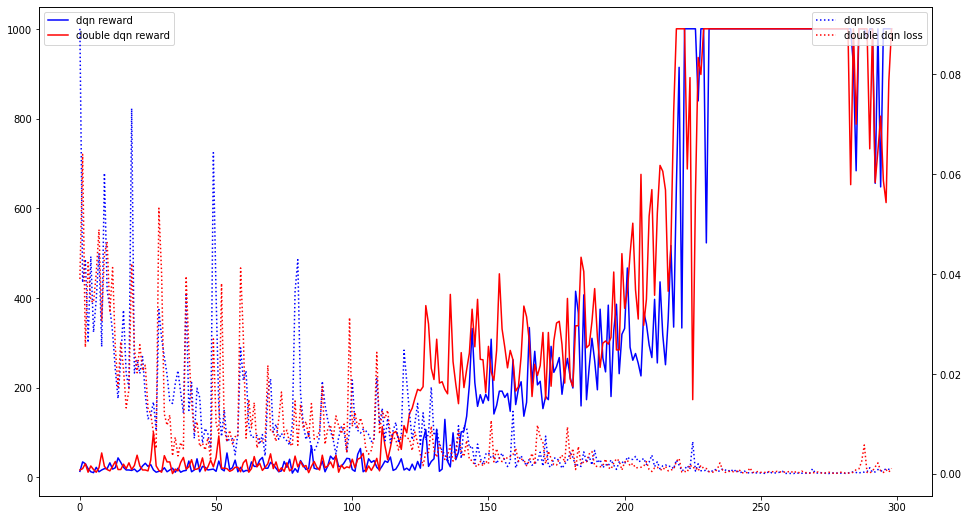

In [ ]:
figure = plt.figure(figsize=(16,9))
ax1 = figure.add_subplot(111)
ax1.plot(dqn_evoluate.epoch_step_list,c='b')
ax1.plot(double_dqn_evoluate.epoch_step_list,c='r')
plt.legend(['dqn reward','double dqn reward'])
ax2 = ax1.twinx()
ax2.plot(dqn_evoluate.loss_value_list,c='b',linestyle=':')
ax2.plot(double_dqn_evoluate.loss_value_list,c='r',linestyle=':')
plt.legend(['dqn loss','double dqn loss'])
plt.show()

# 深度DuelingQ

## 深度DuelingQ学习神经网络

In [ ]:
class network_dueling(torch.nn.Module):
  def __init__(self, env, hidden_dimension=100):
    super().__init__()
    self.env = env
    self.hidden_dimension = hidden_dimension
    self.input_dimension = self.env.observation_space.shape[0]
    self.output_dimension = self.env.action_space.n
    
    self.input_hidden = torch.nn.Linear(self.input_dimension, self.hidden_dimension)
    self.activate = torch.nn.ReLU()
    self.hidden_output_A = torch.nn.Linear(self.hidden_dimension, self.output_dimension)
    self.hidden_output_V = torch.nn.Linear(self.hidden_dimension, self.output_dimension)
    pass

  def forward(self, input):
    # import pdb; pdb.set_trace()
    value_A = self.input_hidden(input)
    value_A = self.activate(value_A)
    value_A = self.hidden_output_A(value_A)
    value_A = value_A - torch.mean(value_A)

    value_V = self.input_hidden(input)
    value_V = self.activate(value_V)
    value_V = self.hidden_output_V(value_V)

    Q = value_A + value_V
    return Q


In [ ]:
class network_dueling_q(network):
  def __init__(self, env, hidden_dimension=100, learning_rate=1e-3):
    # super().__init__(env, hidden_dimension=100, learning_rate=1e-3)
    self.env = env
    self.hidden_dimension = hidden_dimension
    self.learning_rate = learning_rate

    self.input_dimension = self.env.observation_space.shape[0]
    self.output_dimension = self.env.action_space.n
    
    self.model = self.__create_network()
    self.loss = torch.nn.MSELoss()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
    pass

  def __create_network(self):
    # return network(self.env, self.hidden_dimension).model
    return network_dueling(self.env, self.hidden_dimension)

  def __call__(self, state):
    action_value = self.model(state)
    return action_value

## 深度DuelingQ学习智能体&交互环境

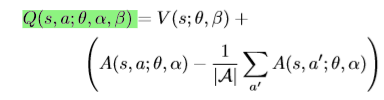

In [ ]:
class agent_dueling_q(agent_q):
  def __init__(self, env, epislon_method=1, gamma=0.99):
    super().__init__(env, epislon_method=1, gamma=0.99)
    self.env = env
    self.epislon_method = epislon_method
    self.gamma = gamma
    if self.epislon_method == 1:
      self.epislon_method =self.epislon_method_1()
    
    self.q_network = network_dueling_q(self.env)
    self.q_network_target = network_dueling_q(self.env)
    self.memory = memory(self.env)
    pass
  
  class epislon_method_1:
    def __init__(self):
      self.epislon_init = 0.01
      self.epislon_increment = 1.001
      self.epislon_max = 0.9
    def update(self):
      if self.epislon_init < self.epislon_max:
        self.epislon_init *= self.epislon_increment
  
  class epislon_method_2:
    def __init__(self):
      self.epislon_init = 0.9
    def update(self):
      pass

In [ ]:
class interactive_dueling_q(interactive):
  def __init__(self, env_name='CartPole-v0', epoch_max=1000, epoch_replace=10):
    super().__init__()
    self.env_name = env_name
    self.epoch_max = epoch_max
    self.epoch_replace = epoch_replace
    self.agent = agent_dueling_q(self.env)
    self.agent = agent_dueling_q(self.env)

## 深度DuelingQ学习执行

In [ ]:
dueling_dqn_evoluate = interactive_dueling_q(epoch_max=300)
dueling_dqn_evoluate.start_execute()

In [ ]:
figure = plt.figure(figsize=(16,9))
ax1 = figure.add_subplot(111)
ax1.plot(dqn_evoluate.epoch_step_list,c='b')
ax1.plot(dueling_dqn_evoluate.epoch_step_list,c='r')
plt.legend(['dqn reward','dueling dqn reward'])
ax2 = ax1.twinx()
ax2.plot(dqn_evoluate.loss_value_list,c='b',linestyle=':')
ax2.plot(dueling_dqn_evoluate.loss_value_list,c='r',linestyle=':')
plt.legend(['dqn loss','dueling dqn loss'], loc='upper right')
plt.show()

In [ ]:
figure = plt.figure(figsize=(16,9))
ax1 = figure.add_subplot(111)
ax1.plot(dqn_evoluate.epoch_step_list,c='b')
ax1.plot(dueling_dqn_evoluate.epoch_step_list,c='r')
plt.legend(['dqn reward','dueling dqn reward'])
ax2 = ax1.twinx()
ax2.plot(dqn_evoluate.loss_value_list,c='b',linestyle=':')
ax2.plot(dueling_dqn_evoluate.loss_value_list,c='r',linestyle=':')
plt.legend(['dqn loss','dueling dqn loss'], loc='upper right')
plt.show()

# 深度双QPriority学习

该部分代码已经另外列出，原因是需要继承的类和函数比较多，因此进行了独立编写。下述代码不可作为实际代码运行。

效果不良。原因在于DQN算法表现在Mountain Car上已经够好。

## 深度双QPriority学习经验池

In [ ]:
class sum_tree:
  def __init__(self, memory_size):
    self.memory_size = memory_size
    self.memory_node = np.zeros(memory_size*2 - 1)
    self.memory_data = np.zeros(memory_size, dtype=object)

    self.priority_upper = 1

    self.memory_pointer = 0
  
  def add(self, transaction, priority_value):
    self.memory_data[self.memory_pointer] = transaction
    self.memory_pointer += 1
    if self.memory_pointer >= self.memory_size:
      self.memory_pointer = 0
    
    memory_index = self.memory_size - 1 + self.memory_pointer
    self.update_index(priority_value, memory_index)
  
  def update_index(self, priority_value, memory_index):
    change_value = priority_value - self.memory_node[memory_index]
    self.memory_node[memory_index] = priority_value
    while memory_index!=0 :
      memory_index = (memory_index -1) // 2
      self.memory_node[memory_index] += change_value
  
  def get(self, priority_choose):
    node_start = 0
    # import pdb; pdb.set_trace()
    while True:
      node_left = node_start*2 + 1
      node_right = node_left + 1
      if node_left >= self.memory_size*2 -1:
        node_end = node_start
        break
      else:
        if priority_choose <= self.memory_node[node_left]:
          node_start = node_left
        else:
          priority_choose -= self.memory_node[node_left]
          node_start = node_right
    data_index = node_end - (self.memory_size - 1)
    return node_end, self.memory_node[node_end], self.memory_data[data_index]

  @property
  def priority_max(self):
    priority_value = np.max(self.memory_node[-self.memory_size:])
    if priority_value <= 0:
      priority_value = self.priority_upper
    return priority_value

  @property
  def priority_min(self):
    priority_value = np.min(self.memory_node[-self.memory_size:])
    return priority_value
  
  @property
  def priority_sum(self):
    return self.memory_node[0]


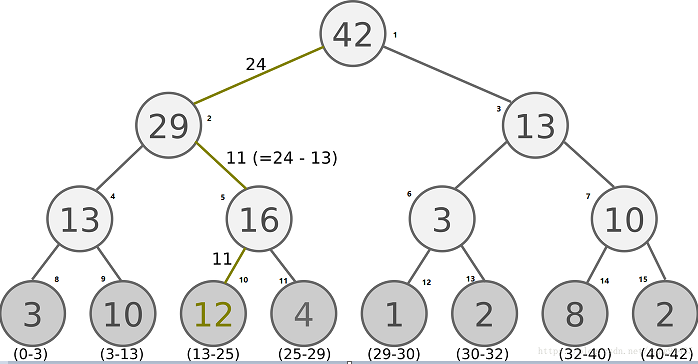

In [ ]:
class memory_priority:
  def __init__(self, env, memory_length=20000, memory_minibatch=32, alpha=0.6, beta=0.4, beta_increment=0.001):
    self.env = env
    self.memory_length = memory_length
    self.memory_minibatch = memory_minibatch
    self.alpha = alpha
    self.beta = beta
    self.beta_increment = beta_increment

    self.state_size = self.env.observation_space.shape[0]
    try:self.action_size = self.env.action_space.shape[0]
    except:self.action_size = 1
    self.memory_width = self.state_size * 2 + self.action_size + 1

    self.memory = sum_tree(self.memory_length)

  def store(self, state, action, reward, next_state):
    transacton = np.hstack((state, action, reward, next_state))
    priority_value = self.memory.priority_max
    self.memory.add(transacton, priority_value)
  
  def sample(self):
    # import pdb; pdb.set_trace()
    priority_index_array = np.empty(self.memory_minibatch)
    memory_array = np.empty((self.memory_minibatch, self.memory_width))
    weight_array = np.empty(self.memory_minibatch)

    priority_segment = self.memory.priority_sum / self.memory_minibatch
    if self.beta < 1:
      self.beta += self.beta_increment
    priority_min = self.memory.priority_min / self.memory.priority_sum
    priority_min += 0.00001
    for i in range(self.memory_minibatch):
      left, right = priority_segment*i, priority_segment*(i+1)
      priority_choose = np.random.uniform(left, right)
      priority_index, priority_value, memory_data = self.memory.get(priority_choose)
      weight = np.power(priority_value/priority_min, -self.beta)

      priority_index_array[i] = priority_index
      weight_array[i] = weight
      memory_array[i,:] = memory_data
    return priority_index_array, weight_array, memory_array

  def batch_update(self, priority_index, absolute_error):
    priority_value = absolute_error + 0.0001
    priority_value = np.min(priority_value, 1)
    store_value = np.power(priority_value, self.alpha)
    for index, value in zip(priority_index, store_value):
      self.memory.update(index, value)


In [ ]:
# env = gym.make('CartPole-v0')
# env = env.unwrapped
# memory_test = memory_priority(env, memory_length=128)
# state = env.reset()
# for _ in range(50):
#   action = env.action_space.sample()
#   next_state, reward, done, _ = env.step(action)
  
#   memory_test.store(state, action, reward, next_state)
#   state = next_state
#   if done :
#     break
# priority_index, weight, memory_data = memory_test.sample()
# # state, action, reward, next_state = memory_test.sample()
# # import pdb; pdb.set_trace()
# print(priority_index)

In [ ]:
%debug

> <ipython-input-15-344087f0a226>(37)get()
     35         break
     36       else:
---> 37         if priority_choose <= self.memory_node[node_left]:
     38           node_start = node_left
     39         else:

ipdb> node_left
31
ipdb> self.memory_node[node_left]
*** IndexError: index 31 is out of bounds for axis 0 with size 31
ipdb> q


## 深度双QPriority学习网络

In [ ]:
class network_priority:
  def __init__(self, env, hidden_dimension=100, learning_rate=1e-3):
    self.env = env
    self.hidden_dimension = hidden_dimension
    self.learning_rate = learning_rate
    self.input_dimension = self.env.observation_space.shape[0]
    self.output_dimension = self.env.action_space.n
    
    self.model = self.__create_network()
    self.loss_mse = torch.nn.MSELoss()
    self.loss_l1 = torch.nn.L1Loss()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
  
  @staticmethod
  def replace(network_from, network_to):
    network_to.load_state_dict(network_from.state_dict())
  
  @staticmethod
  def optimizer(predict_object, predict_value, target_value, weight):
    loss = predict_object.loss_mse(predict_value, target_value)
    predict_object.optimizer.zero_grad()
    loss.backward()
    for param in predict_object.parameters():
      param._grad = param.grad * weight
    predict_object.optimizer.step()
    return loss.item()
  
  def __call__(self, state):
    action_value = self.model(state)
    return action_value

  def __create_network(self):
    return torch.nn.Sequential(torch.nn.Linear(self.input_dimension,self.hidden_dimension),
                            torch.nn.ReLU(),
                            torch.nn.Linear(self.hidden_dimension,self.output_dimension))

## 深度双QPriority学习智能体

In [ ]:
class agent_priority_double_q:
  def __init__(self, env, epislon_method=1, gamma=0.99):
    self.env = env
    self.epislon_method = epislon_method
    self.gamma = gamma

    if self.epislon_method == 1:
      self.epislon_method =self.epislon_method_1()

    self.q_network = network_priority(self.env)
    self.q_network_target = network_priority(self.env)
    self.memory = memory_priority(self.env)


  def output_action(self, state):
    state = torch.from_numpy(state)
    action_value = self.q_network(state)
    action_value = np.array(action_value.tolist())

    random_number = np.random.random()
    if random_number > self.epislon_method.epislon_init:
      action = self.env.action_space.sample()
    else:
      action = np.argmax(action_value)
      action = np.squeeze(action)
    return action, action_value

  def sample_postprocess(self):
    weight_index, weight, memory_data = self.memory.sample()
    state, action, reward, next_state = self.sample_decouple(memory_data)

    state = torch.from_numpy(state)
    next_state = torch.from_numpy(next_state)
    action = np.squeeze(action)
    reward = np.squeeze(reward)
    action = action.astype(np.int32)
    return state, action, reward, next_state, weight, weight_index
  
  def sample_decouple(self, choice_data):
    state = choice_data[:,0:self.memory.state_size]
    action = choice_data[:,self.memory.state_size:self.memory.state_size+self.memory.action_size]
    reward = choice_data[:,self.memory.state_size+self.memory.action_size:
                         self.memory.state_size+self.memory.action_size+1]
    next_state = choice_data[:,self.memory.state_size+self.memory.action_size+1:]
    return state, action, reward, next_state
  
  def learn(self):
    state, action, reward, next_state, weight, weight_index = self.sample_postprocess()

    _ , action_max = torch.max(self.q_network.model(next_state), axis=1)
    target_value = self.q_network_target.model(next_state)
    target_value = np.array(target_value.tolist())
    replace_index = np.arange(self.memory.memory_minibatch, dtype=np.int32)
    target_value = target_value[replace_index, action_max]

    target_value = reward + self.gamma*np.array(target_value.tolist())

    predict_value_all = self.q_network.model(state)

    replace_index = np.arange(self.memory.memory_minibatch, dtype=np.int32)
    target_value_all = np.array(predict_value_all.tolist())
    target_value_all[replace_index,action] = target_value

    self.epislon_method.update()

    return network_priority.optimizer(self.q_network, predict_value_all,
                            torch.from_numpy(target_value_all), weight)

  class epislon_method_1:
    def __init__(self):
      self.epislon_init = 0.01
      self.epislon_increment = 1.001
      self.epislon_max = 0.9
    def update(self):
      if self.epislon_init < self.epislon_max:
        self.epislon_init *= self.epislon_increment
  
  class epislon_method_2:
    def __init__(self):
      self.epislon_init = 0.9
    def update(self):
      pass

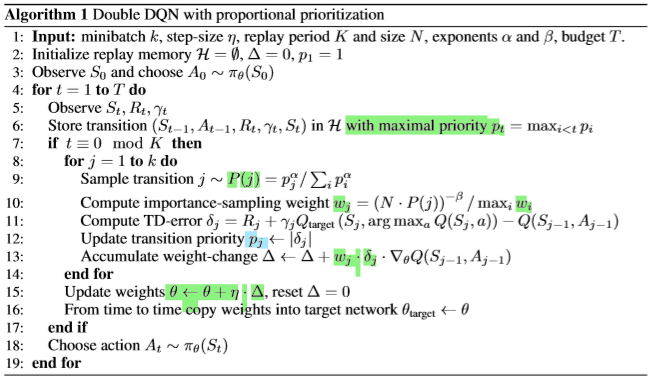

## 深度双QPriority学习交互&执行

In [ ]:
class interactive_priority_double_q(interactive):
  def __init__(self, env_name='CartPole-v0', epoch_max=1000, epoch_replace=10):
    super().__init__()
    self.env_name = env_name
    self.epoch_max = epoch_max
    self.epoch_replace = epoch_replace
    self.agent = agent_priority_double_q(self.env)


In [ ]:
priority_double_dqn_evoluate = interactive_priority_double_q(epoch_max=300)
priority_double_dqn_evoluate.start_execute()

In [ ]:
%debug

#深度双Q分布式学习

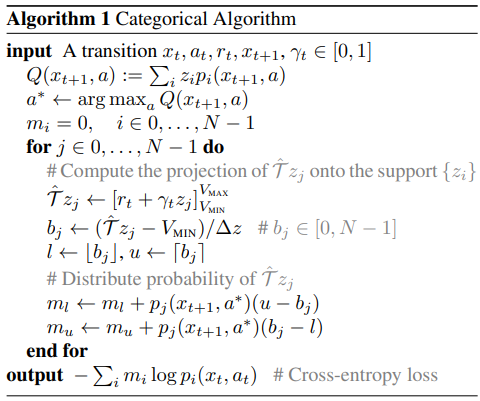

## 深度双Q分布式学习神经网络

In [4]:
class dist_network:
    def __init__(self, env, hidden_dimension=100, learning_rate=1e-3,
                 vmin=0, vmax=100, atoms=51):
        self.env = env
        self.hidden_dimension = hidden_dimension
        self.learning_rate = learning_rate
        self.vmin = vmin
        self.vmax = vmax
        self.atoms = atoms

        self.state_dimension = self.env.observation_space.shape[0]
        try:
            self.action_dimension = self.env.action_space.shape[0]
        except:
            self.action_dimension = 1

        self.delta_z = (self.vmax - self.vmin) / (self.atoms - 1)
        self.z = [i * self.delta_z for i in range(self.atoms)]

        self.p_model = self.__create_network()
        # self.q_model = torch.sum(self.p_model * self.z)
        self.loss = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(
            self.p_model.parameters(), lr=self.learning_rate)

    @staticmethod
    def replace(network_from, network_to):
        network_to.load_state_dict(network_from.state_dict())

    @staticmethod
    def optimizer(predict_object, predict_value, target_value):
        # import pdb; pdb.set_trace()

        p = predict_value
        m = target_value
        loss = -torch.sum(m * torch.log(p))
        predict_object.optimizer.zero_grad()
        loss.backward()
        predict_object.optimizer.step()
        return loss.item()

    class dist_model(torch.nn.Module):
        def __init__(self, state_dimension, action_dimension, hidden_dimension, output_dimension):
            super().__init__()
            self.state_dimension = state_dimension
            self.action_dimension = action_dimension
            self.hidden_dimension = hidden_dimension

            self.layer_state = torch.nn.Linear(
                self.state_dimension, self.hidden_dimension)
            self.layer_action = torch.nn.Linear(
                self.action_dimension, self.hidden_dimension)
            self.layer_output = torch.nn.Linear(
                self.hidden_dimension, output_dimension)

        def forward(self, state, action):
            hidden_state = self.layer_state(state)
            # import pdb; pdb.set_trace()
            hidden_action = self.layer_action(action)
            hidden = hidden_state + hidden_action
            hidden = torch.nn.functional.relu(hidden)
            output = self.layer_output(hidden)
            output = torch.nn.functional.softmax(output, dim=-1)

            return output

    def __create_network(self):
        return self.dist_model(self.state_dimension,
                               self.action_dimension,
                               self.hidden_dimension,
                               self.atoms)

## 深度双Q分布式学习智能体

In [5]:
class agent_dq_dist:
    def __init__(self, env, epislon_method=1, gamma=0.99):
        self.env = env
        self.epislon_method = epislon_method
        self.gamma = gamma

        if self.epislon_method == 1:
            self.epislon_method = self.epislon_method_1()

        self.network = dist_network(self.env)
        self.network_target = dist_network(self.env)

        self.memory = memory(self.env)

        pass

    def output_action(self, state, isgreedy=True, target=False):
        state = torch.from_numpy(state)

        action_list = [i for i in range(self.env.action_space.n)]

        if target is False:
            action_pvalue = [self.network.p_model(state, torch.Tensor([i]))
                             for i in action_list]
        else:
            action_pvalue = [self.network_target.p_model(state, torch.Tensor([i]))
                             for i in action_list]

        action_value = np.zeros(self.env.action_space.n)
        for i in range(self.env.action_space.n):
            action_value[i] = torch.sum(
                action_pvalue[i] * torch.Tensor(self.network.z)).tolist()

        random_number = np.random.random()
        if random_number > self.epislon_method.epislon_init and isgreedy:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(action_value)
            action = np.squeeze(action)
        return action, action_value, action_pvalue[action]

    def sample_postprocess(self):
        state, action, reward, next_state = self.memory.sample()
        # state = torch.from_numpy(state)
        # next_state = torch.from_numpy(next_state)
        action = np.squeeze(action)
        reward = np.squeeze(reward)
        action = action.astype(np.int32)
        return state, action, reward, next_state

    def learn(self):
        state, action, reward, next_state = self.sample_postprocess()
        loss = 0
        for s, a, r, ns in zip(state, action, reward, next_state):
            a_max, _, probably = self.output_action(
                ns, isgreedy=False, target=True)
            probably = probably.tolist()
            m = np.zeros(self.network.atoms)
            # import pdb; pdb.set_trace()
            for i in range(self.network.atoms):
                zj = r + self.gamma * np.array(self.network.z[i])
                bj = (zj - self.network.vmin) / self.network.delta_z
                low = int(np.floor(bj))
                high = int(np.ceil(bj))
                m[low] += probably[i] * (high - bj)
                m[high] += probably[i] * (bj - low)

            probably_predict = self.network.p_model(
                torch.from_numpy(s), torch.Tensor([a]))
            self.epislon_method.update()
            loss += dist_network.optimizer(self.network,
                                           probably_predict, torch.Tensor(m))
        return loss

    class epislon_method_1:
        def __init__(self):
            self.epislon_init = 0.01
            self.epislon_increment = 1.001
            self.epislon_max = 0.9

        def update(self):
            if self.epislon_init < self.epislon_max:
                self.epislon_init *= self.epislon_increment

    class epislon_method_2:
        def __init__(self):
            self.epislon_init = 0.9

        def update(self):
            pass

## 深度双Q分布式学习环境交互

In [6]:
class interactive:
    def __init__(self, env_name='CartPole-v0', epoch_max=1000, epoch_replace=10):
        self.env_name = env_name
        self.epoch_max = epoch_max
        self.epoch_replace = epoch_replace

        self.env = gym.make(self.env_name)
        self.env = self.env.unwrapped
        self.agent = agent_dq_dist(self.env)

    def reward_normalize(self, next_state):
        x, x_dot, theta, theta_dot = next_state
        r1 = (self.env.x_threshold - abs(x)) / self.env.x_threshold - 0.8
        r2 = (self.env.theta_threshold_radians - abs(theta)) / \
            self.env.theta_threshold_radians - 0.5
        reward = r1 + r2
        return reward

    def start_execute(self):
        self.epoch_index = 0
        self.loss_value = 0
        for i in range(self.epoch_max):
            self.epoch_index += 1
            state = self.env.reset()
            self.epoch_step = 0
            while True:
                self.epoch_step += 1
                action, _, _ = self.agent.output_action(state)
                next_state, reward, done, info = self.env.step(action)
                reward = self.reward_normalize(next_state)
                self.agent.memory.store(state, action, reward, next_state)
                state = next_state

                if self.epoch_index > 1:
                    self.loss_value = self.agent.learn()
                if done or self.epoch_step > 1000:
                    break

            if self.epoch_index % self.epoch_replace == 0:
                dist_network.replace(self.agent.network.p_model,
                                     self.agent.network_target.p_model)
            self.statistic()

    def statistic(self):
        if not self.epoch_index > 1:
            self.epoch_step_list = []
            self.loss_value_list = []
        else:
            print('epoch %-5s, length %-5s, loss_value %5f, epislon %5f' %
                  (self.epoch_index, self.epoch_step, self.loss_value, self.agent.epislon_method.epislon_init))
            self.epoch_step_list.append(self.epoch_step)
            self.loss_value_list.append(self.loss_value)

## 深度双Q分布式学习执行

In [7]:
dqn_evoluate = interactive(epoch_max=300)
dqn_evoluate.start_execute()

epoch 2    , length 15   , loss_value 124.441813, epislon 0.016157
epoch 3    , length 10   , loss_value 124.101917, epislon 0.022247
epoch 4    , length 19   , loss_value 124.281814, epislon 0.040849
epoch 5    , length 19   , loss_value 124.233917, epislon 0.075007
epoch 6    , length 19   , loss_value 124.538877, epislon 0.137727
epoch 7    , length 17   , loss_value 124.601264, epislon 0.237223
epoch 8    , length 13   , loss_value 124.685865, epislon 0.359529
epoch 9    , length 19   , loss_value 124.686564, epislon 0.660165
epoch 10   , length 13   , loss_value 124.740146, epislon 0.900847
epoch 11   , length 10   , loss_value 124.887740, epislon 0.900847
epoch 12   , length 10   , loss_value 124.802447, epislon 0.900847
epoch 13   , length 10   , loss_value 124.806992, epislon 0.900847
epoch 14   , length 8    , loss_value 124.898803, epislon 0.900847
epoch 15   , length 10   , loss_value 124.811497, epislon 0.900847
epoch 16   , length 9    , loss_value 124.807468, epislon 0.90

KeyboardInterrupt: ignored

# 工具代码

In [ ]:
print(1)